In [84]:
import json
import pandas
import os
import textdistance

In [83]:
DUMP_DIR = "../cedar-spec/cedar-drt/cedar-afl/dump_out/"


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [110]:
inputs = {}
inputs['000000'] = {
    'src': '000000',
    'time': 0,
    'execs': 0,
}
for f in os.listdir(DUMP_DIR):
    path = os.path.join(DUMP_DIR, f)
    f_split = f.split(",")
    cov = False
    if len(f_split) > 7:
        cov = True
    elif len(f_split) == 4:
        continue
    iid, src, time, execs, op, reason = f_split[:6]
    if len(f_split) > 7:
        cov = True
    try:
        input_src = json.load(open(path, "r"))
        input_dict = {
            "src": src.split(":")[1],
            "time": time,
            "execs": execs,
            "op": op,
            "cov": cov,
            "input": input_src
        }
        inputs[iid.split(":")[1]] = input_dict
    except:
        with open("unfinished.txt", "a") as f2:
            f2.write(f[:-5] + "\n")
        continue

In [104]:
print(len(inputs))

6253


In [ ]:
parent_inputs = {}
for i in inputs:
    print(i)
    try:
        src = inputs[i]["src"]
        if "children" not in inputs[src]:
            inputs[src]["children"] = set()
        inputs[src]["children"].add(i)
    except:
        continue

In [141]:
from langchain.evaluation.parsing.json_distance import JsonEditDistanceEvaluator
evaluator = JsonEditDistanceEvaluator()

In [183]:
import tqdm
dists = []
text_dists = []
rows = []
for i in tqdm.tqdm(inputs):
    if i == "000000":
        continue
    input_dict = inputs[i]
    if "children" in input_dict and "input" in input_dict:
        # print(f"Original data: {input_dict['input']['data']}")
        for c in input_dict["children"]:
            c_dict = inputs[c]
            dist = textdistance.levenshtein.distance(input_dict['input']['data'], c_dict['input']['data'])
            parent_input = json.loads(input_dict['input']['input'])
            child_input = json.loads(c_dict['input']['input'])
            schema_dist = evaluator.evaluate_strings(prediction=json.dumps(parent_input["schema"]), reference=json.dumps(child_input["schema"]))
            entities_dist = evaluator.evaluate_strings(prediction=json.dumps(parent_input["entities"]), reference=json.dumps(child_input["entities"]))
            policy_dist = evaluator.evaluate_strings(prediction=json.dumps(parent_input["policy"]), reference=json.dumps(child_input["policy"]))
            requests_dist = evaluator.evaluate_strings(prediction=json.dumps(parent_input["requests"]), reference=json.dumps(child_input["requests"]))
            rows.append([i, c, dist, c_dict["cov"], schema_dist['score'], entities_dist['score'], policy_dist['score'], requests_dist['score']])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6253/6253 [03:11<00:00, 32.70it/s]


In [184]:
import pandas as pd
df = pd.DataFrame(rows, columns=['parent', 'child', 'cov', 'byte_dist', 'schema_dist', 'entities_dist', 'policies_dist', 'requests_dist'])

In [157]:
df

,parent,child,byte_dist,schema_dist,entities_dist,policies_dist,requests_dist
0,002955,004382,82,0.594243,0.566478,0.000000,0.187959
1,002955,004383,113,0.713590,0.695303,0.000000,0.187959
2,005768,005774,11,0.000000,0.466496,0.008869,0.050847
3,005768,005776,4,0.006593,0.466496,0.008879,0.010955
4,005768,005775,1,0.008791,0.000000,0.000000,0.125894
...,...,...,...,...,...,...,...
3731,004135,005627,77,0.000000,0.000000,0.278944,0.000000
3732,004521,004525,4,0.373512,0.000000,0.000000,0.031537
3733,004521,004527,2,0.138779,0.000000,0.000000,0.010512
3734,004521,006524,2,0.362569,0.000000,0.000000,0.031537


In [179]:
df['input_changed'] = df['entities_dist'] + df['policies_dist'] + df['requests_dist'] != 0

<Axes: >

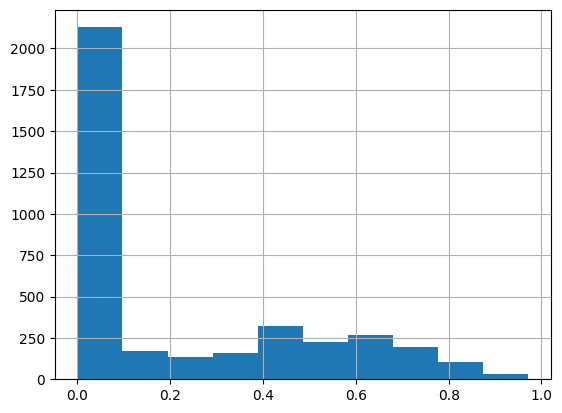

In [168]:
df['schema_dist'].hist()

<Axes: >

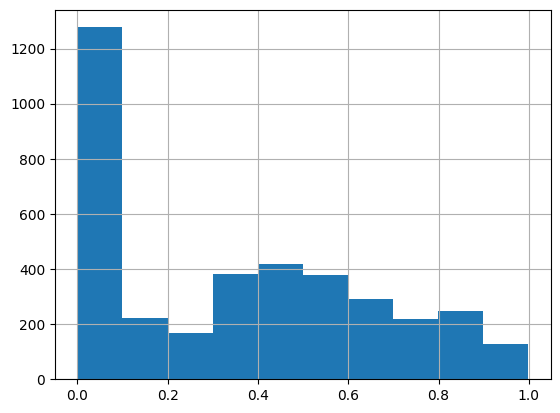

In [169]:
df['entities_dist'].hist()

In [180]:
df['input_changed'].describe()

count     3736
unique       2
top       True
freq      3685
Name: input_changed, dtype: object